# Fig 1 sideways
- network correlation matrix with left bound names
- three tier model precision view
- brain networks color coded by ensembles
- association between ASD conformal scores and behavioural metrics

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib as pal
import scipy as sp
import seaborn as sbn
import nibabel as nib
import warnings
from scipy import cluster as scl
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from nilearn import plotting as nlp
import nilearn.input_data as nii
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import MatplotlibDeprecationWarning

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

In [4]:
import pathlib as pal

# 📁 Base path = where this notebook lives
root_p = pal.Path().resolve()

# 📂 Input paths
pheno_p = root_p / '../../source_data/Data/ABIDE1_Pheno_PSM_matched.tsv'
MIST_p = root_p / '../../source_data/ATLAS/MIST'
labels_p = MIST_p / 'Parcel_Information/MIST_20_nocereb.csv'
atlas_p = MIST_p / 'Parcellations/MIST_20.nii.gz'
mask_p = MIST_p / 'Parcellations/MIST_mask.nii.gz'

# 📊 Results
# Default to precomputed results from Zenodo archive:
discovery_p = root_p / '../../output_data/Results/Discovery'

# 💡 To use your own reproduced results instead, uncomment this:
# discovery_p = root_p / '../../output_data/Discovery'

comb_net_p0_p = str(discovery_p / 'combined_networks_{}_p0.tsv')
comb_net_p1_p = str(discovery_p / 'combined_networks_{}_p1.tsv')
split_net_p0_p = str(discovery_p / 'split_net_{}_p0.tsv')
split_net_p1_p = str(discovery_p / 'split_net_{}_p1.tsv')
all_net_p0_p = str(discovery_p / 'combined_networks_8_p0.tsv')
all_net_p1_p = discovery_p / 'combined_networks_8_p1.tsv'
data_t = discovery_p / 'Results_Instance_{}_Network_{}.csv'

# 📈 Output
fig_p = root_p / '../../output_data/Figures/figure_1_network'
fig_p.mkdir(parents=True, exist_ok=True)

In [5]:
pheno = pd.read_csv(pheno_p, sep='\t')
atlas_i = nib.load(atlas_p)
mask_i = nib.load(mask_p)
has_autism = (pheno.DX_GROUP=='Autism').values.astype(int)
network_labels = pd.read_csv(labels_p, sep=';')

voxel_masker = nii.NiftiMasker(mask_img=mask_i, standardize=False)
voxel_masker.fit()

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x79458058f5b0>,
            memory=Memory(location=None))

In [6]:
results_array = np.stack([[pd.read_csv(str(data_t).format(instance+1, net+1)).values[:, 1:] 
                           for instance in range(100)] 
                          for net in range(18)], -1)

In [7]:
easy_names = ["bas. gangl.","vent. soma.mot.","orb.front. ctx",
              "VMPFC","inf. temp. gyr.","task control",
              "auditory","med. visual","amygd. hippocamp.",
              "dors. soma.mot.","vent. att.","ant. DMN","post.med. DMN",
              "lat. visual","dwnstrm visual","lat. DMN","lat. vent. att.","front.-par."]

In [8]:
network_labels['easy'] = easy_names

In [9]:
def mm2in(mm):
    return mm/25.4

# Remember: those are R-indices -> they start at 1 and go to 410

In [10]:
manual_network_order = [18, 
                        3, 9, 5, 16, 
                        1, 
                        13, 4, 12,
                        2, 7, 10,
                        11, 6, 17,
                        8, 14, 15]
data_order = np.array([12, 3, 11, 0, 2, 8, 4, 15, 17, 7, 13, 14, 10, 16, 5, 9, 6, 1])+1
man_order = np.array(manual_network_order)
#man_order = np.array(data_order)

In [11]:
bootstrap_order = results_array[:, :, 1, 0].astype(int) - 1

## Individual networks

In [12]:
precision = np.zeros(shape=(100, 18))
specificity = np.zeros(shape=(100, 18))
sensitivity = np.zeros(shape=(100, 18))

thr = 0.05

for iteration in range(100):
    for net in range(18):
        test = results_array[iteration, ..., net]
        
        labels = (pheno.iloc[(test[:, 1]-1).astype(int)].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (test[:, 2] > thr) & (test[:, 3] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        sens = tp / p
        spec = tn / n
        ppv = tp / (tp+fp)
        npv = tn / (tn + fn)
        fpr = fp / n
        fdr = fp / (fp + tp)
        
        precision[iteration, net] = ppv
        specificity[iteration, net] = spec
        sensitivity[iteration, net] = sens

In [13]:
table = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(18) for p, spec, sens, n in 
                      [(precision[i, net], 
                        specificity[i, net],
                        sensitivity[i, net],
                        network_labels.iloc[net]['label']) for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))


manual_partition = [0, 
                    1, 1, 1, 1, 
                    2, 
                    3, 3, 3, 
                    4, 4, 4,
                    5, 5, 5,
                    6, 6, 6]
network_names_ordered = [network_labels.loc[o]['label'] for o in man_order-1 ]
group_mapping = {n: f'group_{p+1}' for n, p in zip(network_names_ordered, 
                                 manual_partition)}

table['group'] = [group_mapping[row['network']] for rid, row in table.iterrows()]

# Get me the table index ordered like the networks

table_order = [i for n in network_names_ordered for i in table.query(f'network=="{n}"').index]

table['group'] = [group_mapping[row['network']] for rid, row in table.iterrows()]

## Combined networks

In [14]:
handles=precision_combined = np.zeros(shape=(100, 7))
specificity_combined = np.zeros(shape=(100, 7))
sensitivity_combined = np.zeros(shape=(100, 7))

thr = 0.2

for net in range(7):
    p1 = pd.read_csv(comb_net_p1_p.format(net+1), sep='\t')
    p0 = pd.read_csv(comb_net_p0_p.format(net+1), sep='\t')
    for iteration in range(100):
        # Get the right bootstrap order
        bo = bootstrap_order[iteration, :]
        labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (p1.values[:, iteration] > thr) & (p0.values[:, iteration] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        sens = tp / p
        spec = tn / n
        ppv = tp / (tp+fp)
        npv = tn / (tn + fn)
        fpr = fp / n
        fdr = fp / (fp + tp)

        precision_combined[iteration, net] = ppv
        specificity_combined[iteration, net] = spec
        sensitivity_combined[iteration, net] = sens

In [15]:
table_combined = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(7) for p, spec, sens, n in 
                      [(precision_combined[i, net], 
                        specificity_combined[i, net],
                        sensitivity_combined[i, net],
                        f'group_{net+1}') for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))

## Split networks
The two big network groups

In [16]:
handles=precision_split = np.zeros(shape=(100, 7))
specificity_split = np.zeros(shape=(100, 7))
sensitivity_split = np.zeros(shape=(100, 7))

thr = 0.2

for net in range(2):
    p1 = pd.read_csv(split_net_p1_p.format(net+1), sep='\t')
    p0 = pd.read_csv(split_net_p0_p.format(net+1), sep='\t')
    for iteration in range(100):
        # Get the right bootstrap order
        bo = bootstrap_order[iteration, :]
        labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (p1.values[:, iteration] > thr) & (p0.values[:, iteration] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        try:
            sens = tp / p
            spec = tn / n
            ppv = tp / (tp+fp)
            npv = tn / (tn + fn)
            fpr = fp / n
            fdr = fp / (fp + tp)
        except ZeroDivisionError:
            replace = 0
            sens = replace
            spec = replace
            ppv = replace
            npv = replace
            fpr = replace
            fdr = replace

        precision_split[iteration, net] = ppv
        specificity_split[iteration, net] = spec
        sensitivity_split[iteration, net] = sens

In [17]:
table_split = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(2) for p, spec, sens, n in 
                      [(precision_split[i, net], 
                        specificity_split[i, net],
                        sensitivity_split[i, net],
                        f'group_{net+1}') for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))

In [18]:
# Make a correlation matrix of the asd probabilities for each instance
corr_mat = np.stack([np.corrcoef(results_array[instance, :, 2, :].T) for instance in range(100)], -1)

In [19]:
avg_weight_corr = np.average(corr_mat, 2)

In [20]:
#sim = np.corrcoef(data_stack)
sim = np.average(corr_mat, 2)
dist = 1 - sim[np.triu(np.ones(shape=sim.shape), 1).astype(bool)]
link = scl.hierarchy.linkage(dist, method='average', optimal_ordering=True)
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

In [21]:
def get_patches(mat, part, c='black'):
    tab = pd.DataFrame(data=part, columns=('part',))
    val, ind_start, ind_stop = zip(*[(u, 
                                      tab.query(f'part=={u}').first_valid_index(),
                                      tab.query(f'part=={u}').last_valid_index()) for u in tab.part.unique()])
    patch_list = list()
    for ii in range(0,len(ind_start)):
        p = mpl.patches.Rectangle((ind_start[ii]-0.5,)*2,
                                  ind_stop[ii]-ind_start[ii]+1,
                                  ind_stop[ii]-ind_start[ii]+1,
                                                 angle=0, 
                                                 edgecolor=c,
                                                 facecolor='none' ,
                                                 linewidth=4)
        patch_list.append(p)
    return patch_list

In [22]:
def get_better_patches(mat, part, c):
    tab = pd.DataFrame(data=part, columns=('part',))
    val, ind_start, ind_stop = zip(*[(u, 
                                      tab.query(f'part=={u}').first_valid_index(),
                                      tab.query(f'part=={u}').last_valid_index()) for u in tab.part.unique()])
    patch_list = list()
    print(list(zip(val, c)))
    for ii in range(0,len(ind_start)):
        if val[ii]==0:
            continue
        p = mpl.patches.Rectangle((ind_start[ii]-0.5,)*2,
                                  ind_stop[ii]-ind_start[ii]+1,
                                  ind_stop[ii]-ind_start[ii]+1,
                                                 angle=0, 
                                                 #edgecolor=sbn.xkcd_rgb[c[ii]],
                                                 edgecolor=c[ii],
                                                 facecolor='none' ,
                                                 linewidth=2)
        patch_list.append(p)
    return patch_list

In [23]:
colors = [sbn.xkcd_rgb[col] for col in 
         ['amber', 'heather', 'lemon', 'dark sky blue', 'pale rose', 'easter green', 'khaki']]

In [24]:
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [25]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])

## Describe the networks

In [26]:
def get_extreme(table, var):
    max_net = table.groupby('network')[var].describe()['50%'].idxmax()
    print(var, ' max: ', max_net, table.query('network==@max_net')[var].median())
    min_net = table.groupby('network')[var].describe()['50%'].idxmin()
    print(var, ' min: ', min_net, table.query('network==@min_net')[var].median())

In [27]:
get_extreme(table, 'precision')
get_extreme(table, 'sensitivity')
get_extreme(table, 'specificity')

precision  max:  DMnet_pm 0.6587346024636058
precision  min:  ORBcor_NACC 0.5833333333333334
sensitivity  max:  DMnet_pm 0.17688883943473907
sensitivity  min:  MVISnet 0.12949714758925285
specificity  max:  MOTnet_v 0.9127209360219068
specificity  min:  FPTCnet 0.9004543051285566


In [28]:
def get_median(table, var):
    stats = table.groupby('network')[var].describe()
    avg_val = stats['50%'].median()
    print(f"Average {var} (median across networks): {avg_val}")

In [29]:
get_median(table, 'precision')
get_median(table, 'sensitivity')
get_median(table, 'specificity')

Average precision (median across networks): 0.6189410937432902
Average sensitivity (median across networks): 0.15430703416204164
Average specificity (median across networks): 0.907048234151657


In [30]:
# Show me the group level
for group in part_dict.keys():
    print()
    for val in ['precision', 'specificity', 'sensitivity']:
        group_val = table_combined.query(f'network == "group_{group}"')[[val]].describe().T['50%'].values[0]
        net_val = table.query(f'group == "group_{group}"')[[val, 'network']].groupby('network').median().mean().values[0]
        print(f'{val}: group_{group}: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')


precision: group_1: 65.1% vs individual: 64.1%
specificity: group_1: 96.6% vs individual: 90.9%
sensitivity: group_1: 6.7% vs individual: 15.5%

precision: group_2: 70.0% vs individual: 61.5%
specificity: group_2: 96.5% vs individual: 90.4%
sensitivity: group_2: 7.2% vs individual: 15.0%

precision: group_3: 61.4% vs individual: 61.1%


specificity: group_3: 83.2% vs individual: 90.5%
sensitivity: group_3: 27.4% vs individual: 14.6%

precision: group_4: 67.3% vs individual: 64.3%
specificity: group_4: 92.3% vs individual: 90.7%
sensitivity: group_4: 16.1% vs individual: 16.6%

precision: group_5: 64.4% vs individual: 63.1%
specificity: group_5: 89.0% vs individual: 91.1%
sensitivity: group_5: 19.7% vs individual: 16.2%

precision: group_6: 58.8% vs individual: 61.7%
specificity: group_6: 86.9% vs individual: 90.3%
sensitivity: group_6: 18.4% vs individual: 15.8%

precision: group_7: 62.0% vs individual: 60.9%
specificity: group_7: 87.4% vs individual: 90.8%
sensitivity: group_7: 20.2% vs individual: 14.5%


In [31]:
all_precisions = []
all_specificities = []
all_sensitivities = []

for group in part_dict.keys():
    group_data = table_combined.query(f'network == "group_{group}"')
    
    # Append median values for the group
    all_precisions.append(group_data['precision'].median())
    all_specificities.append(group_data['specificity'].median())
    all_sensitivities.append(group_data['sensitivity'].median())

# Calculate median across all groups
median_precision = np.median(all_precisions) * 100
median_specificity = np.median(all_specificities) * 100
median_sensitivity = np.median(all_sensitivities) * 100

# Print results
print(f"Median Precision (All Groups): {median_precision:.1f}%")
print(f"Median Specificity (All Groups): {median_specificity:.1f}%")
print(f"Median Sensitivity (All Groups): {median_sensitivity:.1f}%")

Median Precision (All Groups): 64.4%
Median Specificity (All Groups): 89.0%
Median Sensitivity (All Groups): 18.4%


In [32]:
# ens_colors = ['#FE9D08', '#1258A6'] # Orange, Blue

In [33]:
# Show me the ensemble
print('ensemble 1')
for val in ['precision', 'specificity', 'sensitivity']:
    group_val = table_split.query(f'network == "group_1"')[[val]].describe().T['50%'].values[0]
    net_val = table.query(f'group in ["group_1", "group_2", "group_3", "group_4"]')[[val, 'network']].groupby('network').median().mean().values[0]
    print(f'{val}: ens1: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')
    
# Show me the ensemble
print('ensemble 2')
for val in ['precision', 'specificity', 'sensitivity']:
    group_val = table_split.query(f'network == "group_2"')[[val]].describe().T['50%'].values[0]
    net_val = table.query(f'group in ["group_4", "group_5", "group_6"]')[[val, 'network']].groupby('network').median().mean().values[0]
    print(f'{val}: ens2: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')

ensemble 1
precision: ens1: 83.4% vs individual: 62.7%
specificity: ens1: 99.0% vs individual: 90.6%
sensitivity: ens1: 5.0% vs individual: 15.5%
ensemble 2
precision: ens2: 67.2% vs individual: 63.0%


specificity: ens2: 97.0% vs individual: 90.7%
sensitivity: ens2: 7.5% vs individual: 16.2%


In [34]:
# Output the table
table_split.to_csv(discovery_p / 'table_split.csv', index=False)  

## Horizontal individual

In [35]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [36]:
# Ensemble colors
ens_colors = ['#FE9D08', '#1258A6'] # Orange, Blue
group_7_colors = ['#FFB647', # Light Orange
                  '#FE2908', # Bright Red
                  '#BF7400', # Burnt Orange
                  '#FED908', # Bright Yellow
                  '#52DD07', # Green
                  '#1258A6', # Blue (same color as above)
                  '#5E12AC'] # Purple
group_18_colors = ['#FFB647', # Light Orange
                   '#FF907E', '#FF6047', '#BF1A00', '#881200', # 2nd group, shades of red
                  '#BF7400', # Burnt Orange
                  '#FFEC7E', '#FFE347', '#BFA200', # 4th group, shades of yellow
                  '#9EEB75', '#77E13E', '#3AA600', # 6th group (prot), shades of green
                   '#6C98CA', '#3B72B0', '#09407D', # 5th group (prot), shades of blue
                  '#9D6ECD', '#783CB5', '#440981'] # 7th group (prot), shades of purple

## Matrices

[(np.int64(1), '#FFB647'), (np.int64(2), '#FF907E'), (np.int64(3), '#FF6047'), (np.int64(4), '#BF1A00'), (np.int64(5), '#881200'), (np.int64(6), '#BF7400'), (np.int64(7), '#FFEC7E'), (np.int64(8), '#FFE347'), (np.int64(9), '#BFA200'), (np.int64(10), '#9EEB75'), (np.int64(11), '#77E13E'), (np.int64(12), '#3AA600'), (np.int64(13), '#6C98CA'), (np.int64(14), '#3B72B0'), (np.int64(15), '#09407D'), (np.int64(16), '#9D6ECD'), (np.int64(17), '#783CB5'), (np.int64(18), '#440981')]


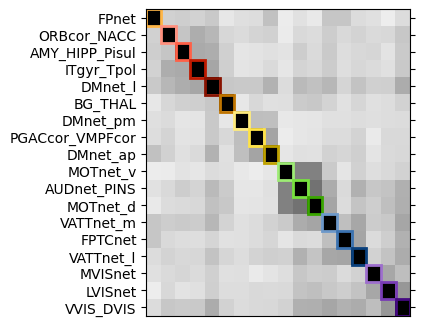

In [37]:
# Matrix 1 (all networks and annotations)
patches = get_better_patches(avg_weight_corr, np.arange(1,19), c=group_18_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 80 * scale_factor
width = 105* scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels(network_labels.loc[order]['label'].values, fontsize=10);
f.savefig(fig_p / 'corr_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(np.int64(1), '#FFB647'), (np.int64(2), '#FF907E'), (np.int64(3), '#FF6047'), (np.int64(4), '#BF1A00'), (np.int64(5), '#881200'), (np.int64(6), '#BF7400'), (np.int64(7), '#FFEC7E'), (np.int64(8), '#FFE347'), (np.int64(9), '#BFA200'), (np.int64(10), '#9EEB75'), (np.int64(11), '#77E13E'), (np.int64(12), '#3AA600'), (np.int64(13), '#6C98CA'), (np.int64(14), '#3B72B0'), (np.int64(15), '#09407D'), (np.int64(16), '#9D6ECD'), (np.int64(17), '#783CB5'), (np.int64(18), '#440981')]


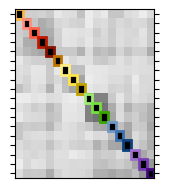

In [38]:
# Matrix 1 (all networks and annotations)
patches = get_better_patches(avg_weight_corr, np.arange(1,19), c=group_18_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')

f.savefig(fig_p / 'corr_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(np.int64(1), '#FFB647'), (np.int64(2), '#FE2908'), (np.int64(3), '#BF7400'), (np.int64(4), '#FED908'), (np.int64(5), '#52DD07'), (np.int64(6), '#1258A6'), (np.int64(7), '#5E12AC')]


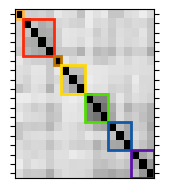

In [39]:
# Matrix 2 (Group 7, no annotations)
patches = get_better_patches(avg_weight_corr, manual_part, c=group_7_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');
f.savefig(fig_p / 'corr_group.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_group.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(np.float64(1.0), '#FE9D08'), (np.float64(2.0), '#1258A6')]


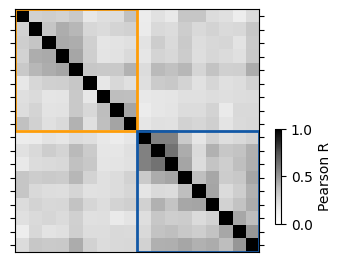

In [40]:
# Matrix 3 (Ensemble 2, no annotations)
patches = get_better_patches(avg_weight_corr, list(np.ones(9)) + list(np.ones(9)*2), c=ens_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 80 * scale_factor
width = 80 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
#gs = gridspec.GridSpec(ncols=1, nrows=10, right=0.9)
gs = gridspec.GridSpec(ncols=1, nrows=10)

ax_dist = f.add_subplot(gs[:, :])
cbaxes = f.add_axes([0.95, 0.2, 0.02, 0.3]) 

#f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');

cbar = f.colorbar(g, cax=cbaxes)
cbaxes.set_ylabel('Pearson R')
ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])

f.savefig(fig_p / 'corr_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

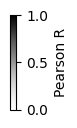

In [41]:
dpi=300
scale_factor = 1
height = 40 * scale_factor
width = 2 * scale_factor

a = np.array([[0,1]])
plt.figure(figsize=(mm2in(width),mm2in(height)))
img = plt.imshow(a, cmap="Greys")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)
cax.set_ylabel('Pearson R', fontsize=10)
cax.set_axis_on()
plt.savefig(fig_p / "colorbar.pdf", bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(np.float64(1.0), '#FE9D08'), (np.float64(2.0), '#1258A6')]


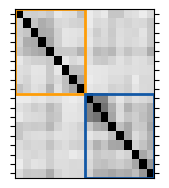

In [42]:
# Matrix 3 (Ensemble 2, no annotations)
patches = get_better_patches(avg_weight_corr, list(np.ones(9)) + list(np.ones(9)*2), c=ens_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])

f.savefig(fig_p / 'corr_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

## Violin Plots

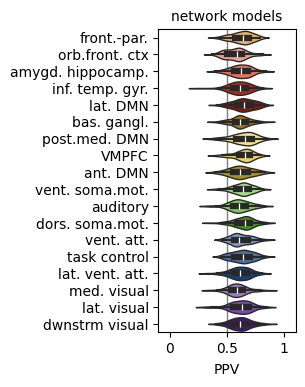

In [43]:
# Violin Plot 1 (all networks, with annotations)

# Network precision
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_individual = f.add_subplot(gs[:, 0])

sbn.set_palette(group_18_colors)
#sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='group', ax=ax_individual, dodge=False, linewidth=lw)
sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='network', ax=ax_individual, dodge=False, linewidth=lw, legend=False)

ylim = ax_individual.get_ylim()
ax_individual.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_individual.set_ylim(ylim)

ax_individual.set_xlim([xlow, xhigh]);
ax_individual.set_ylabel('')
ax_individual.set_xlabel('')
ax_individual.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0, 0.5, 1))
ax_individual.set_xticklabels((0, 0.5, 1))

ax_individual.set_yticklabels(())
ax_individual.set_title('network models', fontsize=10);
ax_individual.set_yticklabels(network_labels.loc[order]['easy'].values, fontsize=10);

f.savefig(fig_p / 'violin_network_easy_names.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_network_easy_names.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

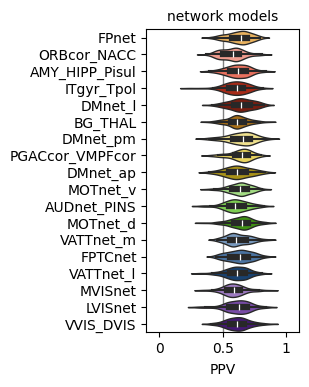

In [44]:
# Violin Plot 1 (all networks, with annotations)

# Network precision
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 50 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_individual = f.add_subplot(gs[:, 0])

sbn.set_palette(group_18_colors)
#sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='group', ax=ax_individual, dodge=False, linewidth=lw)
sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='network', ax=ax_individual, dodge=False, linewidth=lw, legend=False)

ylim = ax_individual.get_ylim()
ax_individual.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_individual.set_ylim(ylim)

ax_individual.set_xlim([xlow, xhigh]);
ax_individual.set_ylabel('')
ax_individual.set_xlabel('')
ax_individual.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0, 0.5, 1))
ax_individual.set_xticklabels((0, 0.5, 1))

ax_individual.set_yticklabels(())
ax_individual.set_title('network models', fontsize=10);
ax_individual.set_yticklabels(network_labels.loc[order]['label'].values, fontsize=10);

f.savefig(fig_p / 'violin_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

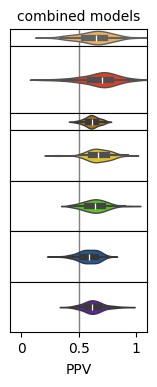

In [45]:
# Violin 2 (group 7, no names)
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

colors = group_7_colors

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_group1 = f.add_subplot(gs[0, 0])
ax_group2 = f.add_subplot(gs[1:5, 0])
ax_group3 = f.add_subplot(gs[5:6, 0])
ax_group4 = f.add_subplot(gs[6:9, 0])
ax_group5 = f.add_subplot(gs[9:12, 0])
ax_group6 = f.add_subplot(gs[12:15, 0])
ax_group7 = f.add_subplot(gs[15:18, 0])

ax_group1.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group2.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group3.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group4.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group5.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group6.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group7.tick_params(axis='both', bottom=True, top=False, right=False, left=False, labelbottom=True, labelleft=False)

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_1"'), color=colors[0], ax=ax_group1, linewidth=lw);
ax_group1.set_ylabel('')
ax_group1.set_yticks([])

ylim = ax_group1.get_ylim()
ax_group1.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_group1.set_ylim(ylim)

ax_group1.set_xlabel('')
ax_group1.set_xlim([xlow, xhigh]);
ax_group1.set_title('combined models', fontsize=10);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_2"'), color=colors[1], ax=ax_group2, linewidth=lw);
ax_group2.set_xlabel('')
ax_group2.vlines(0.5, *[-1.8, 1.8], linewidth=lw, color='grey', zorder=0)
ax_group2.set_ylim([-1.8, 1.8])
ax_group2.set_ylabel('')
ax_group2.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_3"'), color=colors[2], ax=ax_group3, linewidth=lw);
ax_group3.set_xlabel('')
ax_group3.set_ylabel('')

ylim = ax_group3.get_ylim()
ax_group3.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_group3.set_ylim(ylim)

ax_group3.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_4"'), color=colors[3], ax=ax_group4, linewidth=lw);
ax_group4.set_xlabel('')
ax_group4.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group4.set_ylim([-1.5, 1.5])
ax_group4.set_ylabel('')
ax_group4.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_5"'), color=colors[4], ax=ax_group5, linewidth=lw);
ax_group5.set_xlabel('')
ax_group5.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group5.set_ylim([-1.5, 1.5])
ax_group5.set_ylabel('')
ax_group5.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_6"'), color=colors[5], ax=ax_group6, linewidth=lw);
ax_group6.set_xlabel('')
ax_group6.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group6.set_ylim([-1.5, 1.5])
ax_group6.set_ylabel('')
ax_group6.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_7"'), color=colors[6], ax=ax_group7, linewidth=lw);
ax_group7.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group7.set_ylim([-1.5, 1.5])
ax_group7.set_ylabel('')
ax_group7.set_xlabel('')
ax_group7.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_group7.tick_params(axis='x', which='major', labelsize=10)
ax_group7.set_xticks((0, 0.5, 1))
ax_group7.set_xticklabels((0, 0.5, 1))

ax_group7.set_xlim([xlow, xhigh]);

f.savefig(fig_p / 'violin_group.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_group.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

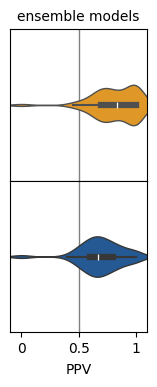

In [46]:
# Violin 2 (ensemble, no names)
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

split_colors = ens_colors

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_split1 = f.add_subplot(gs[:9, 0])
ax_split2 = f.add_subplot(gs[9:, 0])
ax_split1.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_split2.tick_params(axis='both', bottom=True, top=False, right=False, left=False, labelbottom=True, labelleft=False)


sbn.violinplot(x=x_value, y='network', data=table_split.query('network=="group_1"'), color=split_colors[0], 
            ax=ax_split1, linewidth=lw);
ax_split1.set_ylabel('')
ax_split1.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_split1.set_ylim([-1.5, 1.5])
ax_split1.set_yticks([])
ax_split1.set_xlabel('')
ax_split1.set_xlim([xlow, xhigh]);
ax_split1.set_title('ensemble models', fontsize=10);

sbn.violinplot(x=x_value, y='network', data=table_split.query('network=="group_2"'), color=split_colors[1], 
            ax=ax_split2, linewidth=lw);
ax_split2.set_ylabel('')
ax_split2.set_xlabel('')
ax_split2.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_split2.tick_params(axis='x', which='major', labelsize=10)
ax_split2.set_xticks((0, 0.5, 1))
ax_split2.set_xticklabels((0, 0.5, 1))
ax_split2.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_split2.set_ylim([-1.5, 1.5])
ax_split2.set_yticks([])
ax_split2.set_xlim([xlow, xhigh]);

f.savefig(fig_p / 'violin_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

## Networks

In [47]:
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [48]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])

In [49]:
#cmp = LinearSegmentedColormap.from_list('lala', colors, N=7)
cmp_7 = LinearSegmentedColormap.from_list('lala', group_7_colors, N=7)

cmp_2 = LinearSegmentedColormap.from_list('lala', ens_colors, N=2)

In [50]:
cmp = LinearSegmentedColormap.from_list('lala', group_18_colors, N=18)

In [51]:
ens_1 = [1, 2, 3, 4]
ens_2 = [5, 6, 7]

In [52]:
# Remap atlas numbers to the 7 groups
atlas = np.asarray(atlas_i.dataobj).astype(int) 
atlas_masked = np.zeros(shape=(atlas.shape))
atlas_ens1 = np.zeros(shape=(atlas.shape))
atlas_ens2 = np.zeros(shape=(atlas.shape))
atlas_ens = np.zeros(shape=(atlas.shape))
for i in np.arange(1,8):    
    for j in part_dict[i]:
        # convert j to real j
        real_j = network_labels.iloc[j-1].roi
        if i <=4:
            atlas_ens1[atlas==real_j] = i
            atlas_masked[atlas==real_j] = 1
        else:
            atlas_ens2[atlas==real_j] = i
            atlas_masked[atlas==real_j] = 2
        atlas_ens[atlas==real_j] = i
atlas_masked_i = nib.Nifti1Image(atlas_masked, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens_i = nib.Nifti1Image(atlas_ens, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens1_i = nib.Nifti1Image(atlas_ens1, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens2_i = nib.Nifti1Image(atlas_ens2, affine=atlas_i.affine, header=atlas_i.header)

In [53]:
# Remap atlas numbers to the 18 ordering
atlas = np.asarray(atlas_i.dataobj).astype(int) 
atlas_ens = np.zeros(shape=(atlas.shape))

for idx, val in enumerate(order):
    real_j = network_labels.iloc[val].roi
    atlas_ens[atlas==real_j] = idx+1
atlas_ens_i = nib.Nifti1Image(atlas_ens, affine=atlas_i.affine, header=atlas_i.header)

In [54]:
atlas_comb = np.zeros(shape=(atlas.shape))

for comb in part_dict.keys():
    for val in part_dict[comb]:
        real_j = network_labels.iloc[val-1].roi
        atlas_comb[atlas==real_j] = comb
atlas_comb_i = nib.Nifti1Image(atlas_comb, affine=atlas_i.affine, header=atlas_i.header)

## Triple brains

In [55]:
coords = (10,5,0)

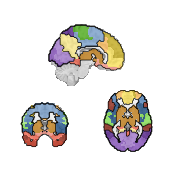

In [56]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=18, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=18, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=18, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_individual.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_individual.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

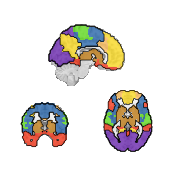

In [57]:
# combined networks
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=7, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=7, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=7, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_combined.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_combined.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

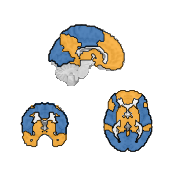

In [58]:
# ensemble
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=2, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=2, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=2, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

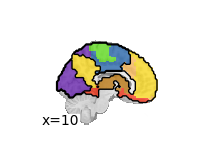

In [59]:
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[0],), display_mode='x', axes=ax, vmin=1, 
                 vmax=7, draw_cross=False, annotate=False, black_bg=False);
g.annotate(size=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)

In [60]:
group_7_colors

['#FFB647', '#FE2908', '#BF7400', '#FED908', '#52DD07', '#1258A6', '#5E12AC']

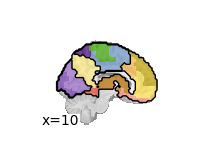

In [61]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[0],), display_mode='x', axes=ax, vmin=1, 
                 vmax=18, draw_cross=False, annotate=False, black_bg=False);
g.annotate(size=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)

fig.savefig(fig_p / 'brain_x.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

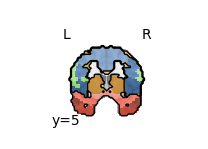

In [62]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[1],), display_mode='y', axes=ax, vmin=1, vmax=18, draw_cross=False, 
             annotate=False, black_bg=False);
g.annotate(size=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)
fig.savefig(fig_p / 'brain_y.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_y.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

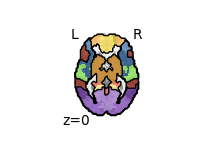

In [63]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[2],), display_mode='z', axes=ax, vmin=1, vmax=18, 
             draw_cross=False, annotate=False, black_bg=False);
g.annotate(size=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)
fig.savefig(fig_p / 'brain_z.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_z.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)